# 시작

In [106]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 데이터 준비

In [107]:
def load_files():
    '''
    훈련, 검증, 시험 데이터 파일명을 불러온다
    파일 크기에 제한을 둘 수 있다
    '''
    path = os.path.join(os.getenv('HOME'),'aiffel','chest_xray')
    train_files = []
    test_files = []
    val_files = []
    for file in tf.io.gfile.glob(path+'/train/*/*'):
        if os.stat(file).st_size >= 15000:
            train_files.append(file)
    for file in tf.io.gfile.glob(path+'/test/*/*'):
        if os.stat(file).st_size >= 15000:
            test_files.append(file)
    for file in tf.io.gfile.glob(path+'/val/*/*'):
        if os.stat(file).st_size >= 15000:
            val_files.append(file)
    # train_files = tf.io.gfile.glob(path+'/train/*/*')
    test_files = tf.io.gfile.glob(path+'/test/*/*')
    # val_files = tf.io.gfile.glob(path+'/val/*/*')
    print('파일 목록을 불러왔습니다')
    print('훈련 데이터: {}개'.format(len(train_files)))
    print('검증 데이터: {}개'.format(len(val_files)))
    print('시험 데이터: {}개'.format(len(test_files)))
    return train_files, val_files, test_files


def split_file_again(train, val):
    '''
    훈련, 검증 데이터를 합친 후, 비율에 맞게 나눈다
    '''
    train_files, val_files =  train_test_split(train + val, test_size=0.2)
    print('파일 목록을 다시 만들었습니다')
    print('훈련 데이터: {}개'.format(len(train_files)))
    print('검증 데이터: {}개'.format(len(val_files)))
    return train_files, val_files


def count_class(files):
    normal_count = len([file for file in files if 'NORMAL' in file])
    print('정상 사진: {}개'.format(normal_count))
    pneumo_count = len([file for file in files if 'PNEUMONIA' in file])
    print('폐렴 사진: {}개'.format(pneumo_count))
    return normal_count, pneumo_count

# TF 데이터셋 변환

In [108]:
def get_label(file):
    '''
    경로에서 라벨을 찾아낸다
    '''
    paths = tf.strings.split(file, os.path.sep)
    return paths[-2] == "PNEUMONIA"


def resize_image(image, target_size=[256, 256]):
    '''
    이미지를 같은 모양으로 재조정한다
    '''
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return tf.image.resize(image, target_size)


def read_image(file):
    '''
    데이터 경로에서 이미지와 라벨을 불러온다
    '''
    label = get_label(file)
    image = tf.io.read_file(file)
    image = resize_image(image)
    return image, label

def augment_image(image, label):
    image = tf.image.random_brightness(image, 0.1)
    # image = tf.image.random_flip_left_right(image)
    return image, label

def make_dataset(files, batch_size, test=False):
    '''
    파일 목록을 데이터 셋으로 만든다
    '''
    dataset = tf.data.Dataset.from_tensor_slices(files)\
                    .map(read_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if test:
        return dataset.batch(BATCH_SIZE)
    else:
        return dataset.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                        .shuffle(buffer_size=1000)\
                        .repeat()\
                        .batch(batch_size=batch_size)\
                        .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# 데이터 시각화 함수

In [109]:
def show_image(images, labels):
    plt.figure(figsize=(10,10))
    for n in range(15):
        ax = plt.subplot(3,5,n+1)
        plt.imshow(images[n], cmap='gray')
        if labels[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
    plt.show()


def draw_dataset(dataset):
    '''
    데이터셋의 이미지를 그려본다
    '''
    image_dataset, label_dataset = next(iter(dataset))
    show_image(image_dataset.numpy(), label_dataset.numpy())

# 모델 생성 함수

In [110]:
def conv_block(size):
    return tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(size, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(size, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])


def dense_block(size, dropout):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(size, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout)
    ])


def define_model():
    return tf.keras.Sequential([
        tf.keras.Input(shape=(256, 256, 1)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])


def make_model():
    model = define_model()
    metrics = [
        'accuracy',
        # 'binary_accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    optimizer = tf.keras.optimizers.Adam()
    loss = tf.keras.losses.BinaryCrossentropy()
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )
    model.summary()
    return model

# 학습 및 결과 함수

In [111]:
def get_class_weight(normal_count, pneumo_count):
    total_count = normal_count + pneumo_count
    normal_weight = (1 / normal_count)*(total_count)/2.0 
    pneumo_weight = (1 / pneumo_count)*(total_count)/2.0
    return {0: normal_weight, 1: pneumo_weight}


def draw_history(history):
    fig, ax = plt.subplots(1, 4, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        if met in history.history:
            ax[i].plot(history.history[met])
            ax[i].plot(history.history['val_' + met])
            ax[i].set_title('Model {}'.format(met))
            ax[i].set_xlabel('epochs')
            ax[i].set_ylabel(met)
            ax[i].legend(['train', 'val'])
        
        
def test_model(model, dataset):
    loss, acc, pre, rec = model.evaluate(dataset)
    print('시험 결과')
    print('accuracy: {}'.format(acc))
    print('recall: {}'.format(rec))

# 메인

In [112]:
train_files, val_files, test_files = load_files()

파일 목록을 불러왔습니다
훈련 데이터: 5141개
검증 데이터: 16개
시험 데이터: 624개


In [113]:
train_files, val_files = split_file_again(train_files, val_files)
train_count = len(train_files)
val_count = len(val_files)

파일 목록을 다시 만들었습니다
훈련 데이터: 4125개
검증 데이터: 1032개


In [114]:
normal_count, pneumo_count = count_class(train_files)

정상 사진: 1076개
폐렴 사진: 3049개


In [115]:
BATCH_SIZE = 16
train_dataset = make_dataset(train_files, BATCH_SIZE)
val_dataset = make_dataset(val_files, BATCH_SIZE)
test_dataset = make_dataset(test_files, BATCH_SIZE, test=True)

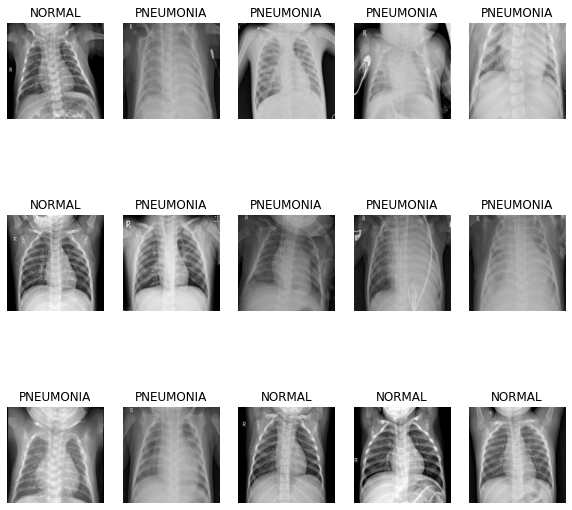

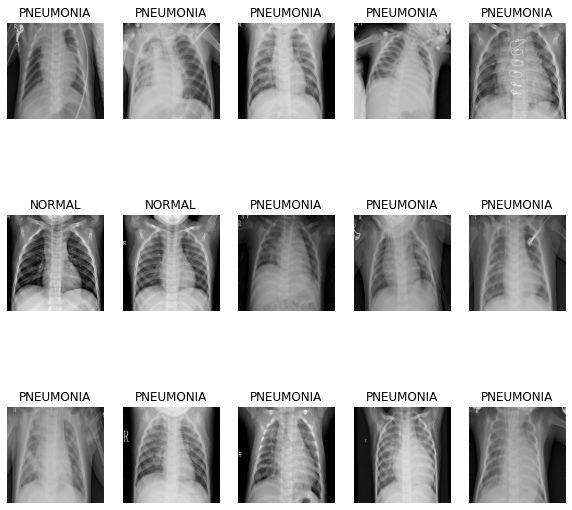

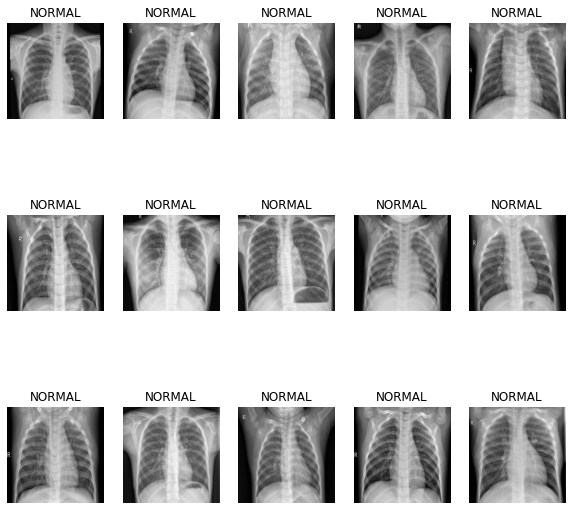

In [116]:
draw_dataset(train_dataset)
draw_dataset(val_dataset)
draw_dataset(test_dataset)

In [117]:
model = make_model()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 256, 256, 16)      160       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 256, 256, 16)      2320      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
sequential_45 (Sequential)   (None, 64, 64, 32)        2160      
_________________________________________________________________
sequential_46 (Sequential)   (None, 32, 32, 64)        7392      
_________________________________________________________________
sequential_47 (Sequential)   (None, 16, 16, 128)       27072     
_________________________________________________________________
dropout_17 (Dropout)         (None, 16, 16, 128)     

In [118]:
class_weight = get_class_weight(normal_count, pneumo_count)

with tf.device('/GPU:0'):
    history = model.fit(
        train_dataset,
        steps_per_epoch=(train_count // BATCH_SIZE),
        epochs=15,
        validation_data=val_dataset,
        validation_steps=(val_count // BATCH_SIZE),
        class_weight=class_weight,
    )

Epoch 1/15
257/257 [==============================] - 24s 95ms/step - loss: 0.3878 - accuracy: 0.8113 - precision: 0.9524 - recall: 0.7838 - val_loss: 0.7462 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 2/15
257/257 [==============================] - 24s 92ms/step - loss: 0.2154 - accuracy: 0.9144 - precision: 0.9759 - recall: 0.9065 - val_loss: 1.2180 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 3/15
257/257 [==============================] - 25s 98ms/step - loss: 0.2139 - accuracy: 0.9210 - precision: 0.9735 - recall: 0.9180 - val_loss: 0.1553 - val_accuracy: 0.9375 - val_precision: 0.9260 - val_recall: 0.9947
Epoch 4/15
257/257 [==============================] - 26s 102ms/step - loss: 0.1814 - accuracy: 0.9336 - precision: 0.9796 - recall: 0.9298 - val_loss: 0.1135 - val_accuracy: 0.9531 - val_precision: 0.9422 - val_recall: 0.9973
Epoch 5/15
257/257 [==============================] - 24s 92ms/step - loss: 0.1480 - accuracy: 

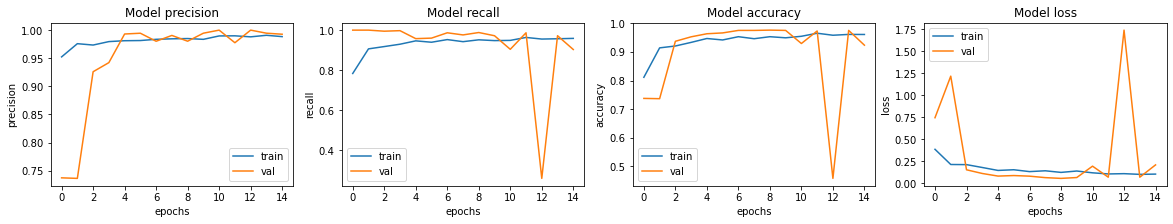

In [119]:
draw_history(history)

In [120]:
test_model(model, test_dataset)

39/39 [==============================] - 1s 22ms/step - loss: 0.4333 - accuracy: 0.8622 - precision: 0.8519 - recall: 0.9436
시험 결과
accuracy: 0.8621794581413269
recall: 0.9435897469520569


# 결과

LMS - accuracy 87%, recall 94%

### 모델 조정

### 15kB, 256, 256, 1, 15epoch, 밝기 0.1     
accuracy: 0.8782051205635071   
recall: 0.928205132484436   
   
accuracy: 0.8189102411270142   
recall: 0.9871794581413269   

accuracy: 0.8541666865348816   
recall: 0.9743589758872986

### 반복 3회

### 128,128,1,  15epoch   
   
accuracy: 0.8092948794364929   
recall: 0.9897435903549194   
   
accuracy: 0.7916666865348816   
recall: 0.9743589758872986   
   
accuracy: 0.7916666865348816   
recall: 0.9743589758872986

### 15kB, 256, 256, 1, 15epoch   

accuracy: 0.8621794581413269   
recall: 0.9435897469520569   
   
accuracy: 0.8461538553237915   
recall: 0.9820512533187866   
   
accuracy: 0.8413461446762085   
recall: 0.9512820243835449

### 15kB, 256, 256, 1, 20epoch, binary_accuracy   
   
accuracy: 0.8461538553237915   
recall: 0.971794843673706   
   
accuracy: 0.8493589758872986   
recall: 0.9871794581413269   

   
accuracy: 0.7051281929016113   
recall: 0.9794871807098389

### 15kB, 256, 256, 1, 20epoch, 밝기 0.1   
accuracy: 0.8333333134651184   
recall: 0.9820512533187866    
   
accuracy: 0.8429487347602844   
recall: 0.9820512533187866   
   
accuracy: 0.7371794581413269   
recall: 0.9897435903549194

### 15kB, 256, 256, 1, 15epoch, 밝기 0.1     
accuracy: 0.8782051205635071   
recall: 0.928205132484436   
   
accuracy: 0.8189102411270142   
recall: 0.9871794581413269   

accuracy: 0.8541666865348816   
recall: 0.9743589758872986

### 15kB, 256, 256, 1, 15epoch, 밝기0.1, 회전0.1   
accuracy: 0.8125   
recall: 0.9589743614196777   

accuracy: 0.8685897588729858   
recall: 0.9538461565971375

### 15kB, 256, 256, 1, 15epoch, 밝기0.1, 이동 0.1   

accuracy: 0.8541666865348816   
recall: 0.9461538195610046   

accuracy: 0.6426281929016113   
recall: 1.0   

accuracy: 0.625   
recall: 1.0

### 데이터 변화

이미지 채널을 1로 설정   
accuracy: 0.7179487347602844   
recall: 1.0

### 이미지 채널을 1로 설정하고 epoch를 15로   
accuracy: 0.879807710647583   
recall: 0.9256410002708435

### 이미지를 130x130, 1채널로 15 epoch   
accuracy: 0.8926281929016113   
recall: 0.9179487228393555

accuracy: 0.8333333134651184
recall: 0.971794843673706

### 용량 제한 15kB, 256x256, 1채널로 15epoch   
accuracy: 0.8205128312110901   
recall: 0.9025641083717346

### 용량 제한 15kB, 256x256, 1채널로 25epoch   
accuracy: 0.8445512652397156   
recall: 0.9692307710647583

용량 제한 15kB, 256x256, 3채널로 25epoch   
accuracy: 0.7724359035491943   
recall: 0.9820512533187866

용량 제한 15kB, 256x256, 3채널로 35epoch   
accuracy: 0.7916666865348816   
recall: 0.9974358677864075

용량 제한 15kB, 256x256, 3채널로 45epoch   
accuracy: 0.7387820482254028   
recall: 0.9948717951774597

사진 좌우 반전   
accuracy: 0.8028846383094788   
recall: 0.9846153855323792

### 사진 좌우 반전, 35epoch   
accuracy: 0.8445512652397156   
recall: 0.9384615421295166

### 사진 좌우 반전, 45epoch   
accuracy: 0.8221153616905212   
recall: 0.9923076629638672

사진 밝기 20% 랜덤   
accuracy: 0.8060897588729858   
recall: 0.9897435903549194

### 사진 밝기 20% 랜덤, 35 epoch   
accuracy: 0.8317307829856873   
recall: 0.9820512533187866

사진 밝기 20% 랜덤, 45 epoch   
accuracy: 0.8108974099159241   
recall: 0.9820512533187866

용량제한 15kB, 256x256, 3채널, 사진 밝기 20% 랜덤   
accuracy: 0.7628205418586731   
recall: 0.9974358677864075

용량제한 15kB, 256x256, 3채널, 사진 밝기 20% 랜덤, 35 epoch   
accuracy: 0.7932692170143127   
recall: 0.9923076629638672   
   
accuracy: 0.8301281929016113   
recall: 0.9871794581413269

### 용량제한 15kB, 256x256, 3채널, 사진 밝기 20% 랜덤, 45 epoch   
accuracy: 0.8589743375778198   
recall: 0.971794843673706

용량제한 15kB, 256x256, 3채널, 사진 밝기 20% 랜덤, 55 epoch   
accuracy: 0.8157051205635071   
recall: 0.9769230484962463

용량제한 15kB, 256x256, 1채널, 사진 밝기 20% 랜덤     
accuracy: 0.7099359035491943   
recall: 1.0

용량제한 15kB, 256x256, 1채널, 35epoch, 사진 밝기 20% 랜덤     
accuracy: 0.7035256624221802
recall: 1.0

### 용량제한 15kB, 256x256, 1채널, 15epoch, 사진 밝기 20% 랜덤     
accuracy: 0.8445512652397156   
recall: 0.971794843673706

용량제한 15kB, 256x256, 1채널, 10epoch, 사진 밝기 20% 랜덤     
accuracy: 0.7371794581413269   
recall: 0.9948717951774597

용량제한 15kB, 128x128, 1채널 15epoch   
accuracy: 0.7612179517745972   
recall: 0.9897435903549194

### 용량제한 15kB, 128x128, 1채널 25epoch   
accuracy: 0.8365384340286255   
recall: 0.9743589758872986

용량제한 15kB, 128x128, 1채널 35epoch   
accuracy: 0.7435897588729858   
recall: 0.9974358677864075

### 모델 변화

시도1. 모든 DROPOUT을 제거   
accuracy: 0.7564102411270142   
recall: 0.9974358677864075

시도2. 모든 Batch Normalization을 제거    
accuracy: 0.7996794581413269   
recall: 0.9358974099159241

### metric에서 accuracy를 binary_accuracy로   
accuracy: 0.8653846383094788    
recall: 0.9820512533187866

### 시도3. metric에서 precition을 제거   
accuracy: 0.8413461446762085   
recall: 0.9820512533187866

시도4. optiomizer를 rmsprop으로   
accuracy: 0.7628205418586731   
recall: 0.9948717951774597

시도5. optimizer를 nadam으로   
accuracy: 0.8493589758872986   
recall: 0.9666666388511658

시도6. 맨 위를 conv_block(16)으로   
accuracy: 0.7644230723381042   
recall: 0.9974358677864075

시도7. 모든 dense_block의 dropout을 0.5로   
accuracy: 0.8509615659713745   
recall: 0.9820512533187866

metric에서 accuracy를 binary_accuracy로, optimizer를 nadam으로      
accuracy: 0.7628205418586731   
recall: 0.9948717951774597   
   
accuracy: 0.7804487347602844   
recall: 0.9974358677864075

### 학습 변화

학습률 0.005   
accuracy: 0.754807710647583   
recall: 0.9948717951774597

학습률 0.005, 45 epoch   
accuracy: 0.7580128312110901   
recall: 0.9948717951774597

# 결론

모델을 변화시킬 경우 결과가 나빠지는 경우가 많아 모델은 LMS를 유지하였다.

전반적으로 데이터 수가 적기 때문에 결과의 편차가 커 더 나은 것을 판단하기 힘들다.   

이미지는 회전과 좌우 반전을 할 경우 전반적으로 결과가 약간 하락했다.   
이미지의 밝기만 변화시켰을 경우 결과의 편차가 줄어들었다.   

이미지의 채널을 1로 하였을경우 연산량을 줄이는 장점이 있어, 채널을 1로 하고 대신 이미지 크기를 늘렸다.    
이미지 원본의 크기를 확인해보니 너무 작은 이미지가 있어, 15kB이하의 이미지는 학습에서 제외하였다.   

최종적으로 얻은 코드에서 결과의 개선이 있다고 하기는 힘들지만, 결과의 편차가 줄어드는 모습을 보였다.